In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import sounding_utils
from xhistogram.xarray import histogram

from importlib import reload
from functools import partial
from joblib import dump

import sys


In [171]:
ds = sounding_utils.open_ds_dkimpara('0000','rap', cluster='c')

In [189]:
hist = histogram(ds.t_h, 
                 bins=np.arange(-60,40,0.5), 
                 dim=['time', 'x', 'y'], density=True)
hist = hist.rename(dict(t_h_bin='bin'))

In [190]:
def quantile_from_hist(quantiles, hist):
    norm_const = hist.isel(heightAboveGround=0).sum(dim='bin').values
    quantiles = np.sort(quantiles) * norm_const
    cdf = compute_cdf(hist)
    
    results = []
    for q in quantiles:
        q_csum = cdf.where(cdf >= q)
        qs = q_csum.idxmin(dim='bin')
        qs = qs.expand_dims({'quantile': [q / norm_const]})
        
        results.append(qs)
    return xr.concat(results, dim='quantile')
    
def compute_cdf(hist):
    csum = hist.cumsum(dim='bin')
    return csum
    
def mean_from_hist(hist): #need really small bins
    hist = hist / hist.isel(heightAboveGround=0).sum(dim='bin').values

    return (hist * hist.bin).sum(dim='bin')

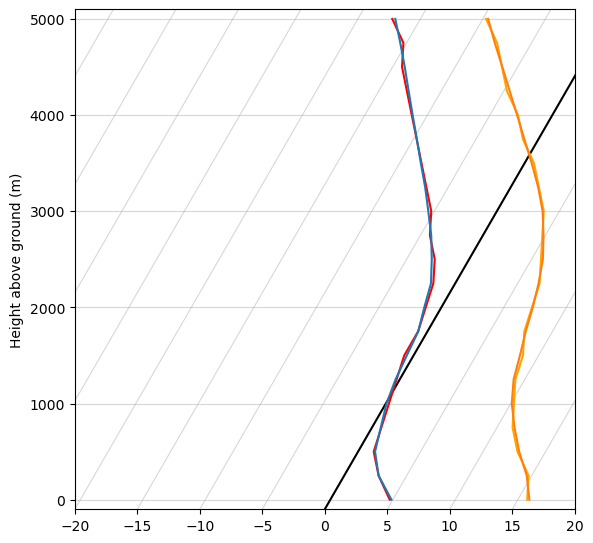

In [193]:
f, ax = sounding_utils.skewCompositeFigAx(figsize=(5, 5))
hq = quantile_from_hist(np.array([0.5, 0.7]), hist)
ax.plot(hq.sel(quantile=0.5), hq.heightAboveGround, color='red')

ax.plot(hq.sel(quantile=0.7), hq.heightAboveGround, color='orange')


quantile = ds.t_h.chunk(dict(time=-1)).quantile(0.5, dim=('x','y','time'))
ax.plot(quantile, ds.heightAboveGround)

quantile = ds.t_h.chunk(dict(time=-1)).quantile(0.7, dim=('x','y','time'))
ax.plot(quantile, ds.heightAboveGround)
